In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/MLPS_final_project/data/covid_fill_x_y.csv'

df = pd.read_csv(file_path)

df.head()

,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wcli,smoothed_wvaccine_likely_friends,...,year,month,day,weekday,is_pseudo_covid_positive,time_value,smoothed_wcovid_vaccinated,is_pseudo_vaccinated,state_fips,state
0,1000.0,34.412959,12.541558,1.464798,65.771681,52.854667,29.288429,30.487852,3.244379,28.469582,...,2021,1,7,3,0,2021-01-07,2.638200,0,1,Alabama
1,2000.0,31.031930,23.187988,5.247612,54.332976,52.948188,8.843686,31.242179,0.421245,29.240819,...,2021,1,7,3,0,2021-01-07,15.910167,0,2,Alaska
2,4000.0,33.894471,15.813525,1.670934,70.449040,52.224064,30.302464,26.614385,1.401254,38.028305,...,2021,1,7,3,0,2021-01-07,4.715310,0,4,Arizona
3,4013.0,30.674532,16.170044,3.106310,68.928567,50.983665,22.710935,24.467235,2.082898,34.448458,...,2021,1,7,3,0,2021-01-07,4.005679,0,4,Arizona
4,4019.0,30.489939,16.193151,2.943076,69.579201,52.706816,21.912277,24.371077,1.306140,36.117471,...,2021,1,7,3,0,2021-01-07,6.249659,0,4,Arizona


In [ ]:
# one-hot encode categorical variables
df['state_fips'] = df['state_fips'].astype(str)
df = pd.get_dummies(df, columns=['state_fips'], drop_first=True)

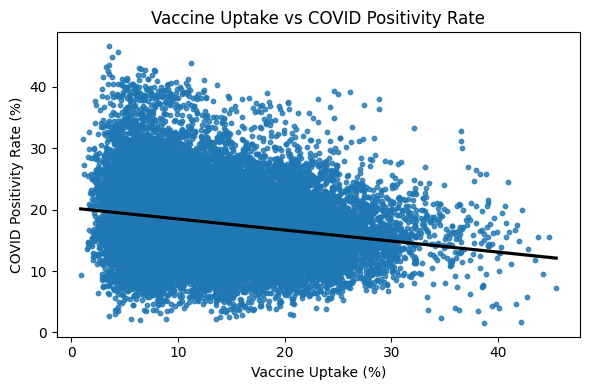

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming your DataFrame is called df and already contains both columns
plt.figure(figsize=(6, 4))
sns.regplot(
    x='smoothed_wcovid_vaccinated',
    y='smoothed_wtested_positive_14d',
    data=df,
    scatter_kws={'s': 10},
    line_kws={'color': 'black'}
)
plt.title('Vaccine Uptake vs COVID Positivity Rate')
plt.xlabel('Vaccine Uptake (%)')
plt.ylabel('COVID Positivity Rate (%)')
plt.tight_layout()
plt.show()


In [ ]:
corr, pval = pearsonr(df['smoothed_wcovid_vaccinated'], df['smoothed_wtested_positive_14d'])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.4f}")

Pearson correlation: -0.206, p-value: 0.0000


In [ ]:
df_with_features = df.copy()

In [ ]:
# Define feature engineering functions
def add_temporal_features(df):
    df = df.copy()
    df['time_value'] = pd.to_datetime(df['time_value'])
    min_date = df['time_value'].min()
    df['days_since_start'] = (df['time_value'] - min_date).dt.days
    df['week_of_year'] = df['time_value'].dt.isocalendar().week
    df['vax_phase'] = (df['time_value'] >= '2021-01-15').astype(int)
    return df

def transform_skewed_features(df, skewed_features):
    df = df.copy()
    for feature in skewed_features:
        if feature in df.columns:
            df[f'{feature}_log'] = np.log1p(df[feature])
    return df

# Identify skewed features
skew_threshold = 1
numeric_cols = df_with_features.select_dtypes(include=[float, int]).columns
skewed_features = df_with_features[numeric_cols].skew().loc[lambda x: abs(x) > skew_threshold].index.tolist()

# Apply transformations
df_with_features = add_temporal_features(df_with_features)
df_with_features = transform_skewed_features(df_with_features, skewed_features)

In [ ]:
# Copy the original DataFrame without feature engineering
df_no_features = df.copy()

In [ ]:
# Define target variable and exclude columns
target_var = 'smoothed_wcovid_vaccinated'
exclude_cols = [
    'time_value', 'geo_value', 'state',
    'smoothed_wtested_positive_14d',
    'is_pseudo_covid_positive', 'is_pseudo_vaccinated',
    target_var
]

In [ ]:
# Prepare X and y for both datasets
X_base = df_no_features.drop(columns=exclude_cols)
y_base = df_no_features[target_var]

X_eng = df_with_features.drop(columns=exclude_cols)
y_eng = df_with_features[target_var]

print("Splitting train/test sets...")
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

print("Scaling features...")
scaler_base = StandardScaler()
X_train_base = scaler_base.fit_transform(X_train_base)

scaler_eng = StandardScaler()
X_train_eng = scaler_eng.fit_transform(X_train_eng)

Splitting train/test sets...
Scaling features...


In [ ]:
print("Defining models...")
models = {
    "Ridge": RidgeCV(),
    "Lasso": LassoCV(),
    "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(64,), max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

def evaluate_model_metrics(model, X, y, cv=5):
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    return {
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std(),
        'r2_mean': r2_scores.mean(),
        'r2_std': r2_scores.std(),
        'mae_mean': mae_scores.mean(),
        'mae_std': mae_scores.std()
    }

def evaluate_all_models(models, X, y, label):
    print(f"Running evaluation for {label} features...")
    results = []
    for name, model in models.items():
        print(f"Evaluating {name}...")
        metrics = evaluate_model_metrics(model, X, y)
        results.append({
            'Features': label,
            'Model': name,
            'RMSE': f"{metrics['rmse_mean']:.3f} ± {metrics['rmse_std']:.3f}",
            'MAE': f"{metrics['mae_mean']:.3f} ± {metrics['mae_std']:.3f}",
            'R²': f"{metrics['r2_mean']:.3f} ± {metrics['r2_std']:.3f}"
        })
    return pd.DataFrame(results)

Defining models...


In [ ]:
print("Starting model evaluation...")
results_base = evaluate_all_models(models, X_train_base, y_train_base, "Base")
results_eng = evaluate_all_models(models, X_train_eng, y_train_eng, "With Feature Engineering")

final_results = pd.concat([results_base, results_eng], ignore_index=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print(final_results)

Starting model evaluation...
Running evaluation for Base features...
Evaluating Ridge...
Evaluating Lasso...
Evaluating NeuralNetwork...
Evaluating XGBoost...
Running evaluation for With Feature Engineering features...
Evaluating Ridge...
Evaluating Lasso...
Evaluating NeuralNetwork...
Evaluating XGBoost...
                   Features          Model           RMSE            MAE             R²
0                      Base          Ridge  3.745 ± 0.054  2.745 ± 0.028  0.683 ± 0.004
1                      Base          Lasso  3.748 ± 0.056  2.749 ± 0.031  0.683 ± 0.004
2                      Base  NeuralNetwork  3.043 ± 0.030  2.252 ± 0.014  0.791 ± 0.004
3                      Base        XGBoost  3.335 ± 0.052  2.418 ± 0.032  0.749 ± 0.004
4  With Feature Engineering          Ridge  3.726 ± 0.054  2.717 ± 0.026  0.686 ± 0.004
5  With Feature Engineering          Lasso  3.732 ± 0.056  2.722 ± 0.028  0.685 ± 0.004
6  With Feature Engineering  NeuralNetwork  2.973 ± 0.044  2.174 ± 0.012  0

In [ ]:
# Final test evaluation using best model: NeuralNetwork + Engineered Features
print("Final Test Set Evaluation: NeuralNetwork + Feature Engineering")

# Rebuild and fit the model
final_nn = MLPRegressor(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)
final_nn.fit(X_train_eng, y_train_eng)

# Transform the test set (already split earlier)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)
y_pred = final_nn.predict(X_test_eng_scaled)

# Calculate metrics
mse_test = mean_squared_error(y_test_eng, y_pred) # Calculate MSE
rmse_test = np.sqrt(mse_test)                  # Calculate RMSE from MSE
mae_test = mean_absolute_error(y_test_eng, y_pred)
r2_test = r2_score(y_test_eng, y_pred)

# Output final test performance
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE:  {mae_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

\Final Test Set Evaluation: NeuralNetwork + Feature Engineering
Test RMSE: 2.879
Test R²: 0.809


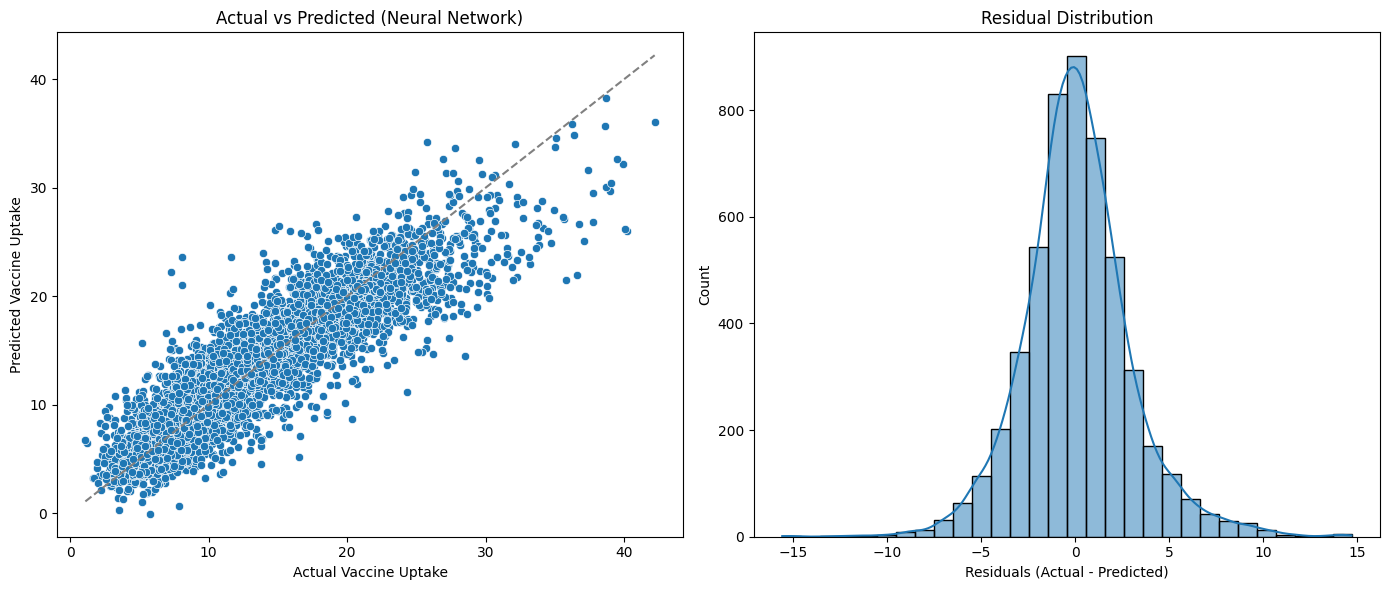

In [ ]:
# 1. Compute residuals
residuals = y_test_eng - y_pred

# 2. Create figure with two subplots
plt.figure(figsize=(14, 6))

# === Scatter Plot: Actual vs Predicted ===
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_eng, y=y_pred)
plt.plot([y_test_eng.min(), y_test_eng.max()], [y_test_eng.min(), y_test_eng.max()], '--', color='gray')
plt.xlabel("Actual Vaccine Uptake")
plt.ylabel("Predicted Vaccine Uptake")
plt.title("Actual vs Predicted (Neural Network)")

# === Residual Plot ===
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()


The scatter plot shows that predicted vaccine uptake closely tracks actual values, with most points hugging the ideal diagonal. The residual plot confirms low bias and variance in predictions, with errors normally distributed and centered around zero. This supports the conclusion that the model is both accurate and well-calibrated.

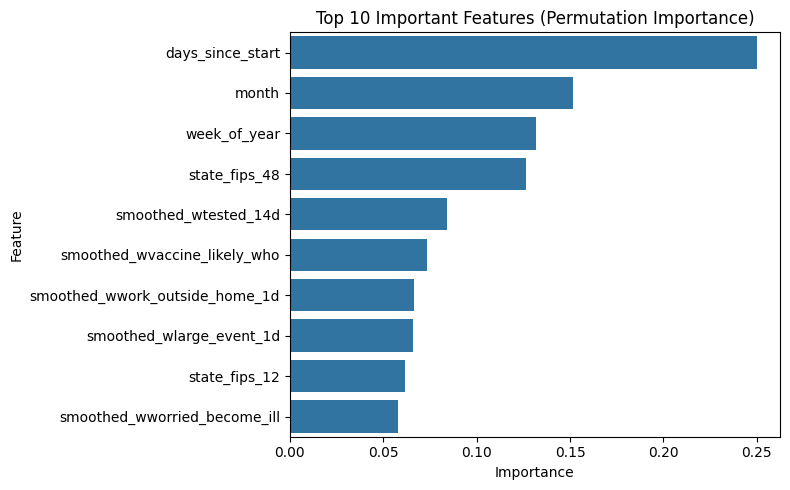

In [ ]:
# Compute permutation importance
result = permutation_importance(final_nn, X_test_eng_scaled, y_test_eng, n_repeats=10, random_state=42)

# Get top 10 features
importance_df = pd.DataFrame({
    'Feature': X_eng.columns,
    'Importance': result.importances_mean
}).sort_values(by="Importance", ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x="Importance", y="Feature")
plt.title("Top 10 Important Features (Permutation Importance)")
plt.tight_layout()
plt.show()

Permutation importance revealed that temporal features (days_since_start, month) and behavioral signals (e.g., smoothed_wtested_14d, smoothed_wworried_become_ill) were among the top drivers of vaccine uptake. Geographic indicators (e.g., state_fips_48) and institutional trust (smoothed_wvaccine_likely_who) also played influential roles.